<a href="https://colab.research.google.com/github/Sandeep-4469/Machine-learning-assignments/blob/main/Project_K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The general process for ARIMA models is the following:

*   Visualize the Time Series Data
*   Make the time series data stationary
*   Plot the Correlation and AutoCorrelation Charts
*   Construct the Models






#Import Libraries

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

#Downloading and CSV_2_DF

In [1]:
!wget -O data.csv https://www.dropbox.com/scl/fi/o7233oyy5ztnrq3kmolrj/DOM_hourly.csv?rlkey=8ax4e5ojld8ir5ivq9m8h9ag1&st=25jsg22t&dl=1

--2024-10-08 16:25:52--  https://www.dropbox.com/scl/fi/o7233oyy5ztnrq3kmolrj/DOM_hourly.csv?rlkey=8ax4e5ojld8ir5ivq9m8h9ag1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca8ae6e350daf3999eb1eff3ed0.dl.dropboxusercontent.com/cd/0/inline/CcHDzQKjkFSf6SVypMWuotRYN_xeWioP4SxYKG9uGzQ6o3O5Wg4LVnIWBukirDtVuU-Sw2CxngD_NEZNnufJMn7q-1MCuT_yO5__5Eps9ftdspIauXAvVace-O40k8JAF4Ds2Z_dT0PDNF0FvKD8Ees5/file# [following]
--2024-10-08 16:25:53--  https://uca8ae6e350daf3999eb1eff3ed0.dl.dropboxusercontent.com/cd/0/inline/CcHDzQKjkFSf6SVypMWuotRYN_xeWioP4SxYKG9uGzQ6o3O5Wg4LVnIWBukirDtVuU-Sw2CxngD_NEZNnufJMn7q-1MCuT_yO5__5Eps9ftdspIauXAvVace-O40k8JAF4Ds2Z_dT0PDNF0FvKD8Ees5/file
Resolving uca8ae6e350daf3999eb1eff3ed0.dl.dropboxusercontent.com (uca8ae6e350daf3999eb1eff3ed0.dl.dropboxusercontent.com)... 162.125.81.15, 262

In [4]:
df = pd.read_csv('data.csv')
df

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0
...,...,...
116184,2018-01-01 20:00:00,18418.0
116185,2018-01-01 21:00:00,18567.0
116186,2018-01-01 22:00:00,18307.0
116187,2018-01-01 23:00:00,17814.0


#EDA

In [5]:
df.isnull().sum()

,0
Datetime,0
DOM_MW,0


In [7]:
df.describe()

,DOM_MW
count,116189.000000
mean,10949.203625
std,2413.946569
min,1253.000000
25%,9322.000000
50%,10501.000000
75%,12378.000000
max,21651.000000


In [8]:
df['Datetime']=pd.to_datetime(df['Datetime'])

In [9]:
df.set_index('Datetime',inplace=True)

##Data Visualisation

<Axes: xlabel='Datetime'>

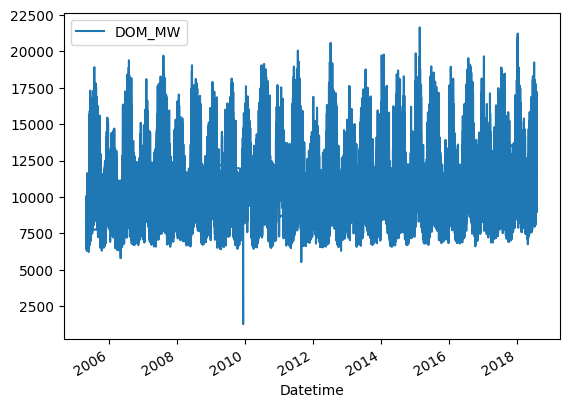

In [10]:
df.plot()

##Stationary Test

In [15]:
def is_stationary(series):
    adf_result = adfuller(series)
    return adf_result[1] <= 0.05

def make_stationary(series):
    differenced_data = series.copy()
    num_differences = 0

    while not is_stationary(differenced_data):
        differenced_data = differenced_data.diff().dropna()
        num_differences += 1
        print(f"Applied differencing: {num_differences}")

    return differenced_data

In [12]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data has no unit root and is stationary")
        return 0
    else:
        print("Time series has a unit root, indicating it is non-stationary ")
        return 1

In [16]:
p = adfuller_test(df['DOM_MW'])

ADF Test Statistic : -15.006910125497667
p-value : 1.069441269623761e-27
#Lags Used : 71
Number of Observations Used : 116117
Data has no unit root and is stationary


In [18]:
if p==1:
  df_stat = make_stationary(df['DOM_MW'])

else:
  df_stat = df.copy()

In [19]:
df_stat

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0
...,...
2018-01-01 20:00:00,18418.0
2018-01-01 21:00:00,18567.0
2018-01-01 22:00:00,18307.0


##Selecting optimal lag from AutoCorrelation chart

<Figure size 1000x600 with 0 Axes>

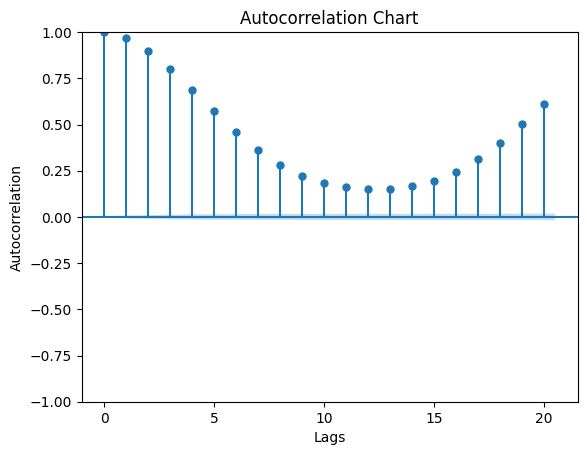

In [20]:
plt.figure(figsize=(10, 6))
plot_acf(df_stat['DOM_MW'], lags=20)  # You can adjust the number of lags
plt.title('Autocorrelation Chart')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

<Figure size 1000x600 with 0 Axes>

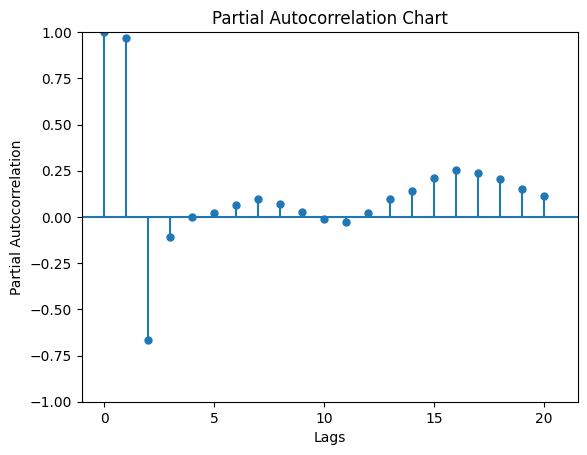

In [21]:
plt.figure(figsize=(10, 6))
plot_pacf(df_stat['DOM_MW'], lags=20)
plt.title('Partial Autocorrelation Chart')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

#Models